In [3]:
import pickle

# Load the banshee.pkl file
with open('banshee.pkl', 'rb') as file:
    banshee = pickle.load(file)

In [4]:
data = banshee[:8000]  # First 8000 samples
audio_data = banshee

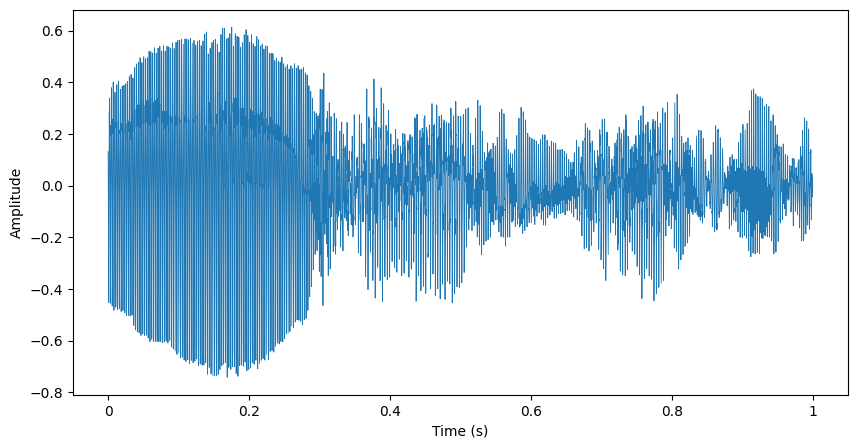

In [14]:
import matplotlib.pyplot as plt
import numpy as np




plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10, 5))  # Set a large figure size
plt.plot(audio_data[:8000]/max(abs(audio_data)), linewidth=.6)  # Plot the first 8000 samples
#plt.title('Recorded Audio Segment')
plt.xlabel('Time (s)')
plt.xticks([0,int(8000/5),2*int(8000/5),int(8000/5)*3,int(8000/5)*4,8000],[0,.2,.4,.6,.8,1])
plt.ylabel('Amplitude')
plt.yticks()
plt.show()

<class 'numpy.ndarray'>
8000 8000


Text(0, 0.5, 'Magnitude')

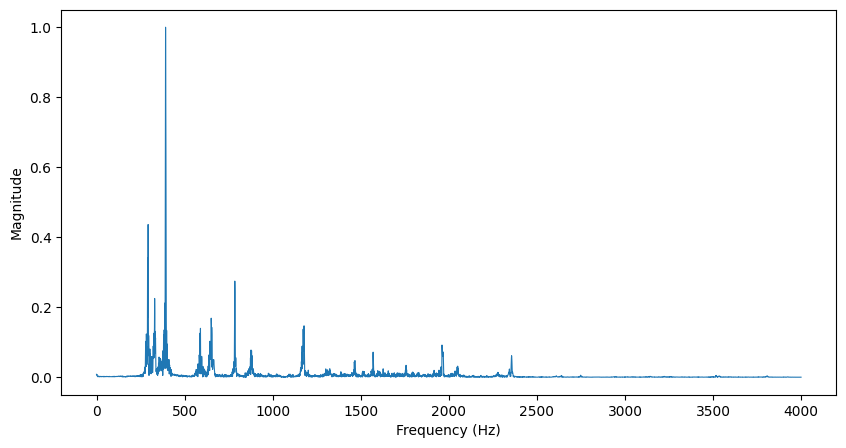

In [18]:
data = audio_data[:8000]
print(type(data))
fs = 8000
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second duration
print(len(t),len(data))
fft_result = np.fft.fft(data)
freqs = np.fft.fftfreq(len(data), 1/fs)

# Take positive frequencies
positive_freqs = freqs[:len(freqs)//2]
magnitude = np.abs(fft_result)[:len(freqs)//2]
magnitude = (magnitude - np.min(magnitude)) / (np.max(magnitude) - np.min(magnitude) + 1e-10)

# Plot time and frequency domains
plt.figure(figsize=(10, 5))

plt.plot(positive_freqs, magnitude,linewidth=.8)  # Plot the magnitude spectrum
#plt.title("Fourier Transform (Magnitude)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")

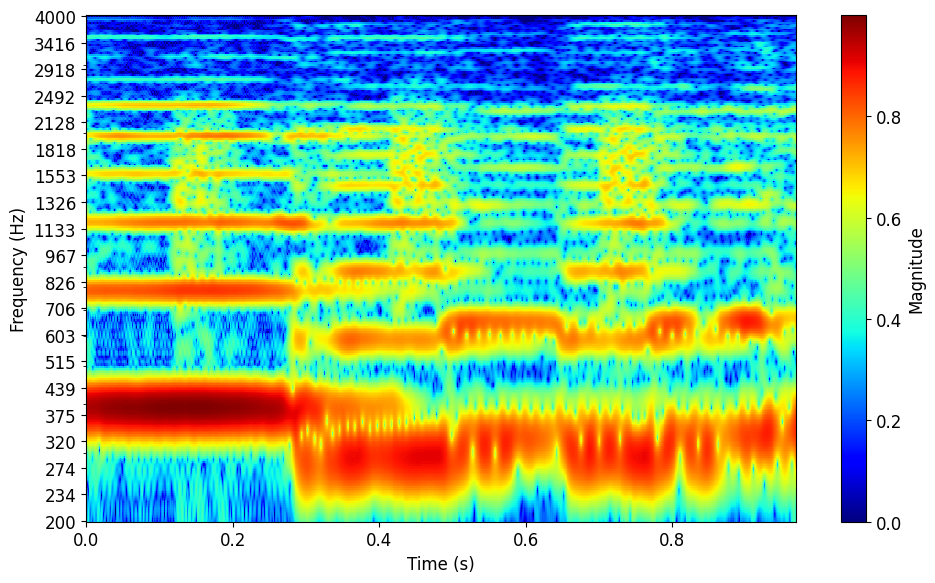

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from scipy.interpolate import interp1d
plt.rcParams.update({'font.size': 12})

def normalize_to_unit(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min + 1e-10)

def gabor_transform(x, window_size, hop_size, fft_size, fs, sig):
    g = get_window(('gaussian', window_size / sig), window_size)
    g = g / np.linalg.norm(g)
    num_frames = 1 + (len(x) - window_size) // hop_size
    result = np.zeros((fft_size // 2 + 1, num_frames), dtype=np.complex64)

    for m in range(num_frames):
        start = m * hop_size
        frame = x[start:start + window_size] * g
        spectrum = np.fft.rfft(frame, n=fft_size)
        result[:, m] = spectrum

    time = np.arange(num_frames) * hop_size / fs
    freq = np.fft.rfftfreq(fft_size, d=1/fs)
    return np.abs(result), time, freq

# === Parameters and Signal ===
fs = 8000
t = np.linspace(0, 1, fs, endpoint=False)
x = data  # Your signal
sig = 6
window_size = 250
hop_size = 10
fft_size = 1000

# === Gabor Transform ===
G, time, freq = gabor_transform(x, window_size, hop_size, fft_size, fs, sig)

# === Normalize THEN convert to dB ===
G = normalize_to_unit(G)
G_dB = 20 * np.log10(G + 1e-6)
G_dB = np.clip(G_dB, -80, 0)  # Optional: restrict dynamic range
G_dB = normalize_to_unit(G_dB)

# === Log-frequency Interpolation ===
log_freqs = np.geomspace(200, freq[-1], num=300)
interp_mag = interp1d(freq, G_dB, axis=0, kind='linear', bounds_error=False, fill_value=0)
G_log = interp_mag(log_freqs)

# === Plotting ===
yticks = np.geomspace(200, 4000, num=20)
ytick_labels = [f"{int(f)}" for f in yticks]

plt.figure(figsize=(10, 6))
plt.pcolormesh(time, log_freqs, G_log, shading='auto', cmap='jet')
plt.yscale('log')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.yticks(yticks, labels=ytick_labels)
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.savefig('gabor_narrow.png', dpi=300)
plt.show()



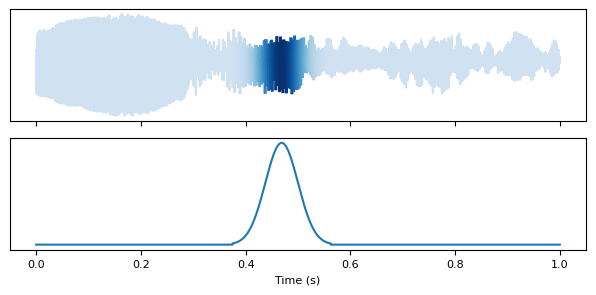

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from matplotlib.collections import LineCollection
plt.rcParams.update({'font.size': 8})
# Signal parameters
fs = 8000
t = np.linspace(0, 1, fs, endpoint=False)
x = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 660 * t)  # Example signal

# Gabor transform parameters
window_size = 1500
hop_size = 10
frame_index = 300
start = frame_index * hop_size
end = start + window_size

# Gaussian window (normalized for display)
sigma = window_size / 6
g = get_window(('gaussian', sigma), window_size)
g /= np.max(g)
g_min = 50 / 255

norm_g = g * (1 - g_min) + g_min  # scale g to [g_min, 1]
# Get low end of colormap for inactive signal color
low_color = plt.cm.Blues(.392/2)  # RGBA tuple from Reds colormap

# --- Create top plot with gradient highlight ---
fig, axs = plt.subplots(2, 1, figsize=(6, 3), sharex=True)

# Plot inactive regions with low-end color
axs[0].plot(t[:start], data[:start], color=low_color, linewidth=1.5)
axs[0].plot(t[end:], data[end:], color=low_color, linewidth=1.5)

# Create gradient-colored overlay for active region
highlight_t = t[start:end]
highlight_x = data[start:end]

# Create gradient color segments
points = np.array([highlight_t, highlight_x]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = plt.cm.Blues(norm_g[:-1])  # map window shape to red colormap
lc = LineCollection(segments, colors=colors, linewidth=2)
axs[0].add_collection(lc)
axs[0].set_yticks([])  # Hide y-ticks for clarity
#axs[0].set_title('Signal with Gaussian-Weighted Region')
#axs[0].set_ylabel('Amplitude')

# --- Bottom plot: Gaussian window positioned in zero array ---
w_plot = np.zeros_like(x)
w_plot[start:end] = g
axs[1].plot(t, w_plot)
#axs[1].set_title('Gaussian Window Positioned on Signal')
axs[1].set_xlabel('Time (s)')
#axs[1].set_ylabel('Amplitude')
axs[1].set_yticks([])  # Hide y-ticks for clarity


plt.tight_layout()
plt.savefig('gaussian_window.png')
plt.show()



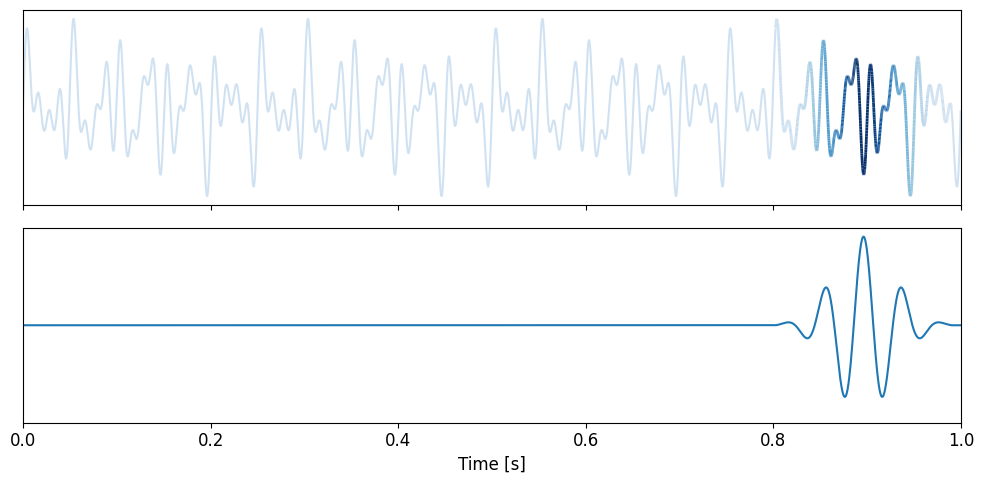

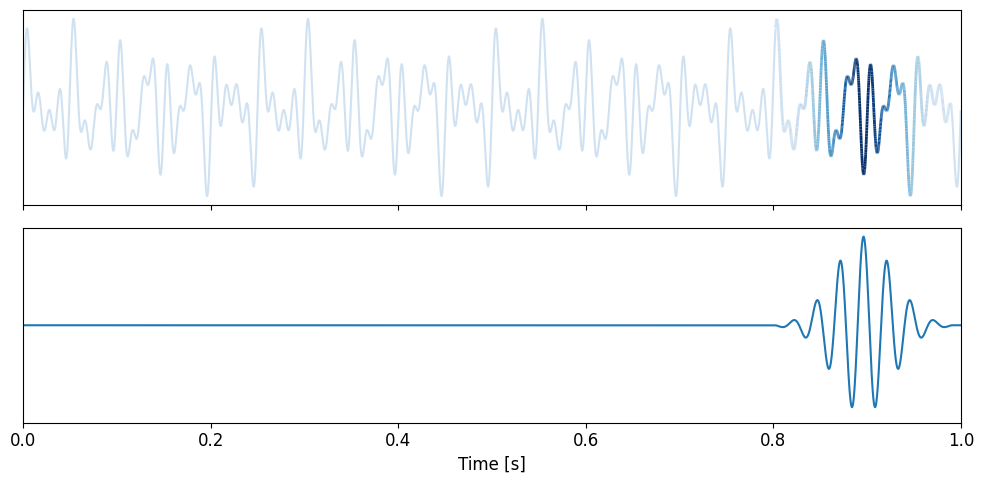

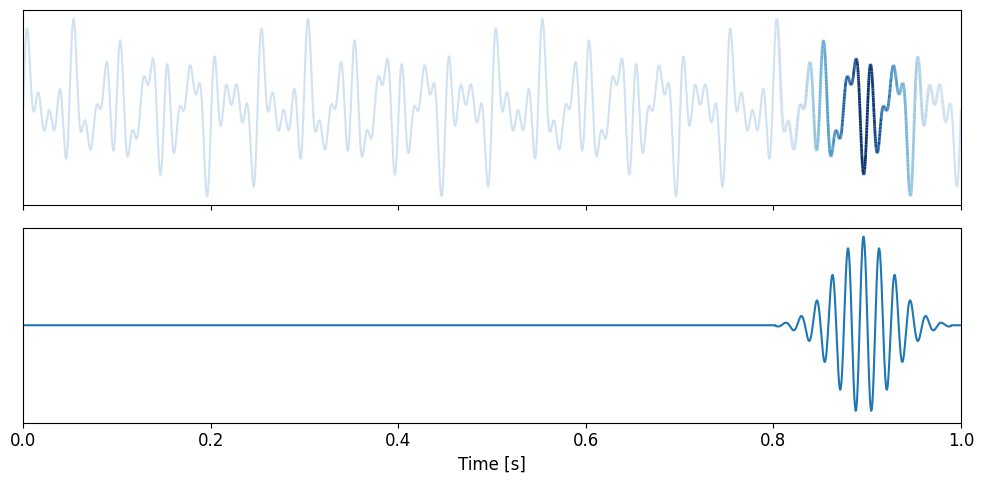

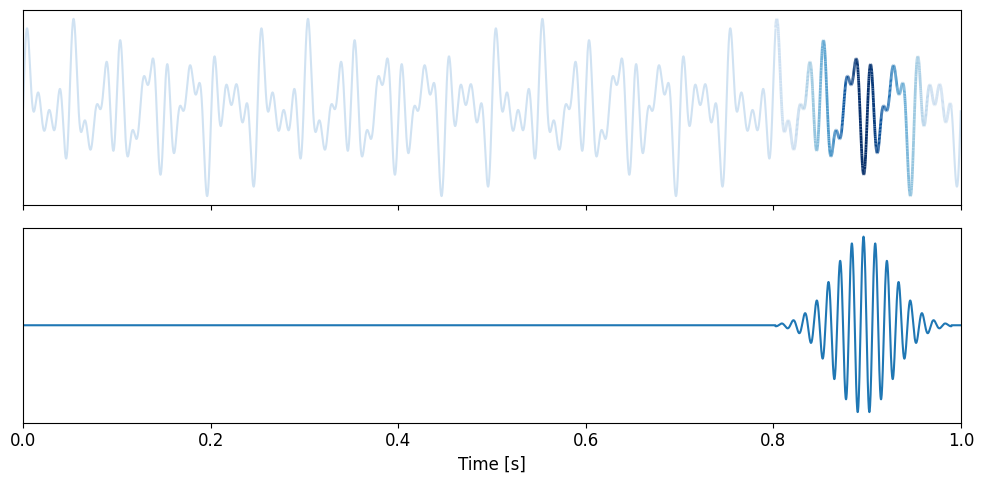

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

# Signal parameters
fs = 8000
t = np.linspace(0, 1, fs, endpoint=False)
x = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 660 * t) 
# Frequencies in cycles per sample
frequencies = [0.003, 0.005, 0.0075, 0.01]
# Generate signal: sum of sinusoids
signal = sum(np.sin(2 * np.pi * f * np.arange(fs)) for f in frequencies) # Example signal
signal /= np.max(np.abs(signal))
data1 = signal

#x = data
# Gabor transform parameters
window_size = 1500
hop_size = 60
sigma = window_size / 6
f0 = .005  # cycles per sample for Morlet



# Morlet wavelet (real part)
n = np.arange(window_size)
t_wave = n - window_size / 2
morlet_real = np.cos(2 * np.pi * f0 * t_wave) * np.exp(-t_wave**2 / (2 * sigma**2))

# Gaussian window (for coloring)
g = morlet_real * np.exp(-t_wave**2 / (2 * sigma**2))
g = np.exp(-0.5 * ((np.arange(window_size) - window_size / 2) / sigma) ** 2)
g /= np.max(g)
g_min = 50 / 255
norm_g = g * (1 - g_min) + g_min

# Colormap for inactive signal
low_color = plt.cm.Blues(.392 / 2)

# Set up plot
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

line_inactive1, = axs[0].plot([], [], color=low_color, linewidth=1.5)
line_inactive2, = axs[0].plot([], [], color=low_color, linewidth=1.5)
lc_active = LineCollection([], linewidth=2)
axs[0].add_collection(lc_active)
axs[0].set_yticks([])

wavelet_line, = axs[1].plot([], [])
axs[1].set_yticks([])
axs[1].set_xlabel("Time [s]")

axs[0].set_xlim(0, 1)
axs[0].set_ylim(data1.min() * 1.1, data1.max() * 1.1)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(-1.1, 1.1)

def init():
    line_inactive1.set_data([], [])
    line_inactive2.set_data([], [])
    lc_active.set_segments([])
    wavelet_line.set_data([], [])
    return line_inactive1, line_inactive2, lc_active, wavelet_line

def update(frame_index):
    start = frame_index * hop_size
    end = start + window_size
    if end > len(data1):
        return line_inactive1, line_inactive2, lc_active, wavelet_line

    # Top plot (highlighted region)
    line_inactive1.set_data(t[:start], data1[:start])
    line_inactive2.set_data(t[end:], data1[end:])
    highlight_t = t[start:end]
    highlight_x = data1[start:end]
    points = np.array([highlight_t, highlight_x]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = plt.cm.Blues(norm_g[:-1])
    lc_active.set_segments(segments)
    lc_active.set_color(colors)

    # Bottom plot (wavelet)
    w_plot = np.zeros_like(x)
    w_plot[start:end] = morlet_real
    wavelet_line.set_data(t, w_plot)

    return line_inactive1, line_inactive2, lc_active, wavelet_line

num_frames = (len(data) - window_size) // hop_size

ani = FuncAnimation(
    fig, update, frames=num_frames, init_func=init,
    blit=True, interval=30, repeat=False
)

#ani.save(f'gifs/g{i}.gif', writer='pillow', fps=20)
plt.tight_layout()
plt.show()


In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# --- Parameters ---
fs = 8000
duration = 1.0
n_samples = int(fs * duration)
frequencies = [0.003, 0.005, 0.0075, 0.01]
frequencies.reverse()  # cycles/sample
n_segments = 20
segment_len = n_samples // n_segments
t = np.arange(n_samples)

# --- Generate synthetic signal with random frequency segments ---
rng = np.random.default_rng(42)
signal = np.zeros(n_samples)
masks = {f: np.zeros(n_samples, dtype=bool) for f in frequencies}

for i in range(n_segments):
    start = i * segment_len
    end = start + segment_len
    t_seg = np.arange(segment_len)
    
    # Weighted selection to make 0.003 less likely
    weights = [0.2 if f == 0.003 else 1.0 for f in frequencies]
    prob = np.array(weights) / np.sum(weights)

    n_freqs = rng.integers(0, len(frequencies)+1)
    freqs_here = rng.choice(frequencies, size=n_freqs, replace=False, p=prob)

    segment = np.zeros(segment_len)
    for f in freqs_here:
        segment += np.sin(2 * np.pi * f * t_seg)
        masks[f][start:end] = True
    segment *= np.hanning(segment_len)
    signal[start:end] += segment


signal /= np.max(np.abs(signal))
signal += 0.00 * rng.normal(size=n_samples)


([], [])

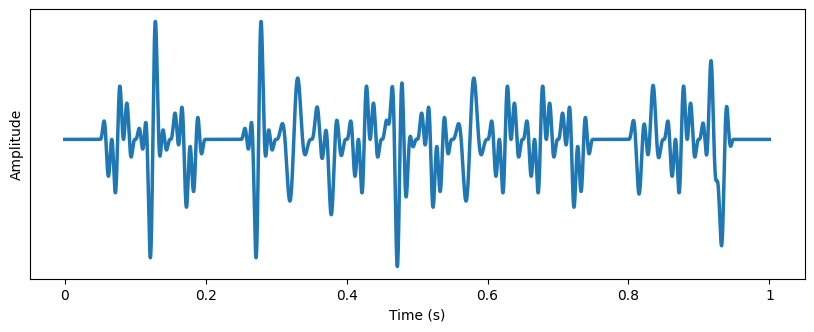

In [45]:
# Signal parameters
fs = 8000*4
t = np.linspace(0, 1*4, fs, endpoint=False)
x = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 660 * t) 
# Frequencies in cycles per sample
frequencies = [0.003, 0.005, 0.0075, 0.01]
# Generate signal: sum of sinusoids
signal1 = sum(np.sin(2 * np.pi * f * np.arange(fs)) for f in frequencies) # Example signal
signal1 /= np.max(np.abs(signal))

plt.figure(figsize=(10, 3.5))
plt.plot(signal, linewidth=2.5)
plt.xlabel('Time (s)',fontsize=10)
plt.ylabel('Amplitude',fontsize=10)
plt.xticks([0,int(8000/5),2*int(8000/5),int(8000/5)*3,int(8000/5)*4,8000],[0,.2,.4,.6,.8,1])
plt.yticks([])

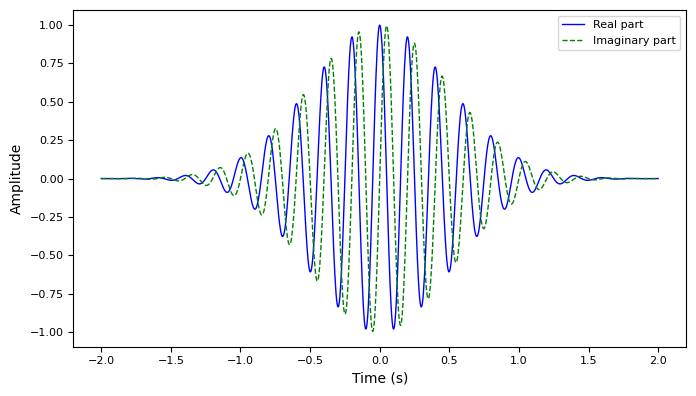

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Define time vector
t = np.linspace(-2, 2, 1000)

# Morlet wavelet parameters
f0 = 5      # Central frequency in Hz
sigma = .5   # Standard deviation of Gaussian

# Construct the Morlet wavelet
morlet_real = np.exp(-t**2 / (2 * sigma**2)) * np.cos(2 * np.pi * f0 * t)
morlet_imag = np.exp(-t**2 / (2 * sigma**2)) * np.sin(2 * np.pi * f0 * t)
morlet_wavelet = morlet_real + 1j * morlet_imag

# Plot the real and imaginary parts
plt.figure(figsize=(7, 4))
plt.plot(t, morlet_real, label='Real part', color='blue',linewidth=1)
plt.plot(t, morlet_imag, label='Imaginary part', color='green', linestyle='--',linewidth = 1)
plt.xlabel('Time (s)',fontsize=10)
plt.ylabel('Amplitude',fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
# Signal parameters
fs = 8000
t = np.linspace(0, 1, fs, endpoint=False)
x = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 660 * t) 
# Frequencies in cycles per sample
frequencies = [0.003, 0.005, 0.0075, 0.01]
# Generate signal: sum of sinusoids
signal = sum(np.sin(2 * np.pi * f * np.arange(fs)) for f in frequencies) # Example signal
signal /= np.max(np.abs(signal))

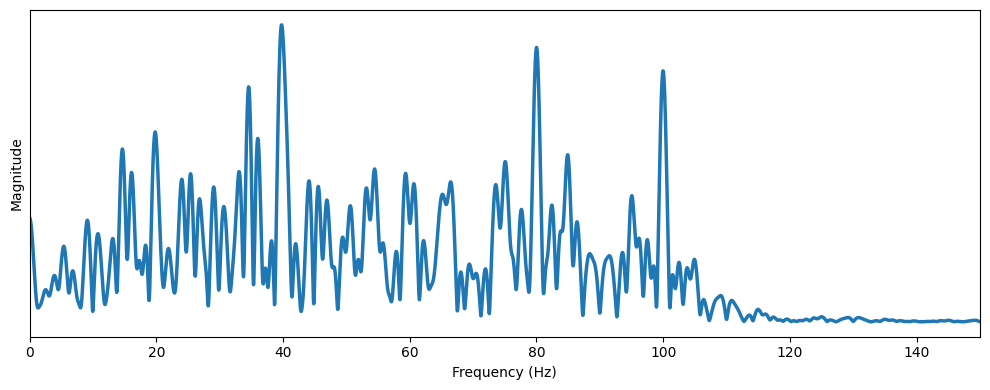

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Sampling parameters
fs = 8000
n = fs*4
t = np.arange(n)

# Frequencies in cycles per sample
frequencies = [0.003, 0.005, 0.0075, 0.01]

n_fft = 8 * n  # 8x zero-padding — experiment with this factor
fft_vals = np.fft.fft(signal*4, n=n_fft)
fft_freqs = np.fft.fftfreq(n_fft, d=1/fs)

# Keep only positive frequencies
pos_mask = fft_freqs >= 0
fft_vals = fft_vals[pos_mask]
fft_freqs = fft_freqs[pos_mask]

# Now plot just the part you're interested in
focus_mask = fft_freqs <= 100
magnitude = np.abs(fft_vals)#[focus_mask]
fft_freqs = fft_freqs#[focus_mask]


# Get magnitude and apply smoothing
magnitude = np.abs(fft_vals)
magnitude_smooth = gaussian_filter1d(magnitude, sigma=2)  # adjust sigma for more or less smoothing

# Plot smoothed spectrum
plt.figure(figsize=(10, 4))
plt.plot(fft_freqs, magnitude_smooth,linewidth=2.5)
plt.xlabel("Frequency (Hz)",fontsize=10)
plt.ylabel("Magnitude",fontsize=10)
plt.grid(False)
plt.xlim(0, 150)
plt.yticks([])  # Limit x-axis to 1000 Hz for better visibility
plt.tight_layout()
plt.show()




In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# --- Parameters ---
fs = 8000
duration = 1.0
n_samples = int(fs * duration)
frequencies = [0.003, 0.005, 0.0075, 0.01]
frequencies.reverse()  # cycles/sample
n_segments = 20
segment_len = n_samples // n_segments
t = np.arange(n_samples)

# --- Generate synthetic signal with random frequency segments ---
rng = np.random.default_rng(42)
signal = np.zeros(n_samples)
masks = {f: np.zeros(n_samples, dtype=bool) for f in frequencies}

for i in range(n_segments):
    start = i * segment_len
    end = start + segment_len
    t_seg = np.arange(segment_len)
    
    # Weighted selection to make 0.003 less likely
    weights = [0.2 if f == 0.003 else 1.0 for f in frequencies]
    prob = np.array(weights) / np.sum(weights)

    n_freqs = rng.integers(0, len(frequencies)+1)
    freqs_here = rng.choice(frequencies, size=n_freqs, replace=False, p=prob)

    segment = np.zeros(segment_len)
    for f in freqs_here:
        segment += np.sin(2 * np.pi * f * t_seg)
        masks[f][start:end] = True
    segment *= np.hanning(segment_len)
    signal[start:end] += segment


signal /= np.max(np.abs(signal))
signal += 0.00 * rng.normal(size=n_samples)


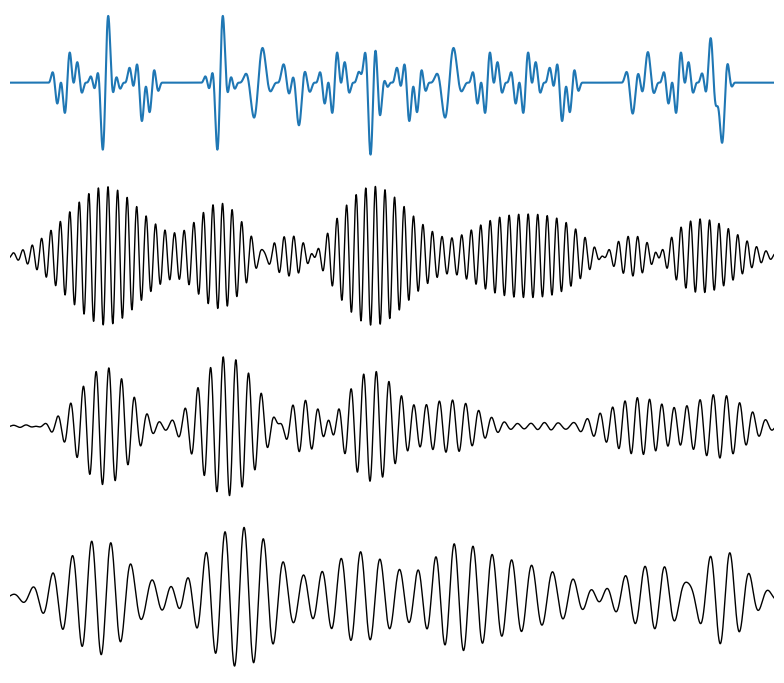

In [119]:

# --- Morlet convolution ---
window_size = 1500
sigma = window_size / 6
n = np.arange(window_size)
t_wave = n - window_size / 2

convolutions = {}
for f in frequencies:
    morlet = np.cos(2 * np.pi * f * t_wave) * np.exp(-t_wave**2 / (2 * sigma**2))
    conv = fftconvolve(signal, morlet, mode='same')
    convolutions[f] = conv

# --- Plot ---
fig, axs = plt.subplots(4, 1, figsize=(8, 7), sharex=True)
for ax in axs:
    for spine in ax.spines.values():
        spine.set_visible(False)

time = np.linspace(0, duration, n_samples, endpoint=False)
axs[0].plot(time, signal)
#axs[0].set_title("Original Signal")
axs[0].set_yticks([])

for i, f in enumerate(frequencies[:-1]):
    axs[i+1].plot(time, convolutions[f], color='black', linewidth=1)
    #axs[i].set_ylabel(f"{f:.4f}", rotation=0, labelpad=40)
    axs[i+1].set_yticks([])
    axs[i+1].set_xlim(0, duration)
    axs[i+1].set_xticks([])

plt.tight_layout()
plt.show()


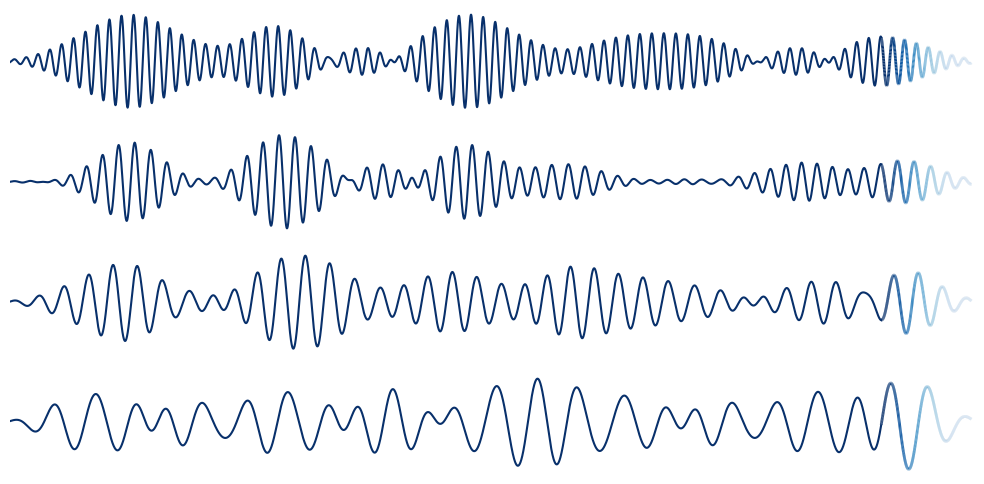

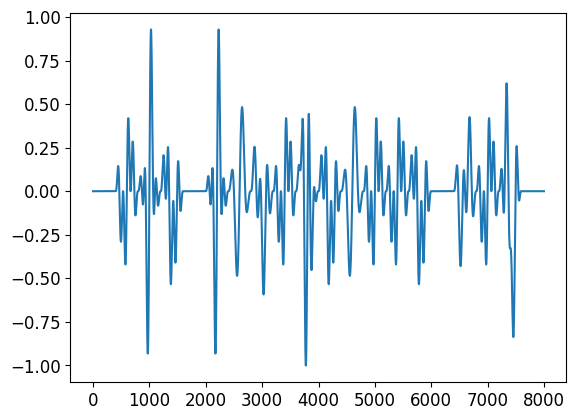

In [250]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from scipy.signal import fftconvolve

# --- Parameters ---
fs = 8000
duration = 1.0
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
frequencies = [0.003, 0.005, 0.0075, 0.01]
frequencies.reverse()  # cycles/sample
window_size = 1500
hop_size = 60
sigma = window_size / 6
n = np.arange(window_size)
t_wave = n - window_size / 2

# --- Signal ---

# --- Convolutions ---
convolutions = {}
for f in frequencies:
    morlet = np.cos(2 * np.pi * f * t_wave) * np.exp(-t_wave**2 / (2 * (sigma)**2))
    conv = fftconvolve(signal, morlet, mode='same')
    convolutions[f] = conv / np.max(np.abs(conv))

# --- Gaussian for color ---
g = np.exp(-0.5 * ((n - window_size / 2) / sigma) ** 2)
g /= np.max(g)
g_min = 50 / 255
norm_g = g * (1 - g_min) + g_min

# --- Plot setup ---
fig, axs = plt.subplots(4, 1, figsize=(10, 5), sharex=True)
lines_inactive = []
lc_actives = []

for ax in axs:
    ax.set_xlim(0, duration)
    ax.set_ylim(-1.1, 1.1)
    ax.set_yticks([])
    ax.set_xticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    line_inactive, = ax.plot([], [], linewidth=1.5)
    lc_active = LineCollection([], linewidth=2)
    ax.add_collection(lc_active)

    lines_inactive.append(line_inactive)
    lc_actives.append(lc_active)

#axs[-1].set_xticks([0, 0.5, 1])

# --- Animation logic ---
def init():
    for line in lines_inactive:
        line.set_data([], [])
    for lc in lc_actives:
        lc.set_segments([])
    return lines_inactive + lc_actives

def update(frame_idx):
    start = frame_idx * hop_size
    end = start + window_size
    if end > len(t):
        return []

    for i, f in enumerate(frequencies):
        y = convolutions[f]

        lines_inactive[i].set_data(t[:start + 750], y[:start + 750])
        lines_inactive[i].set_color(plt.cm.Blues(norm_g[750:-1][0]))

        highlight_t = t[start + 750:end]
        highlight_y = y[start + 750:end]
        points = np.array([highlight_t, highlight_y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        colors = plt.cm.Blues(norm_g[750:-1])
        lc_actives[i].set_segments(segments)
        lc_actives[i].set_color(colors)

    return lines_inactive + lc_actives

num_frames = 120

ani = FuncAnimation(
    fig, update, frames=num_frames, init_func=init,
    blit=True, interval=30, repeat=False
)

plt.tight_layout()
ani.save('convolution_animation.gif', writer='pillow', fps=20)

plt.show()
plt.plot(signal)

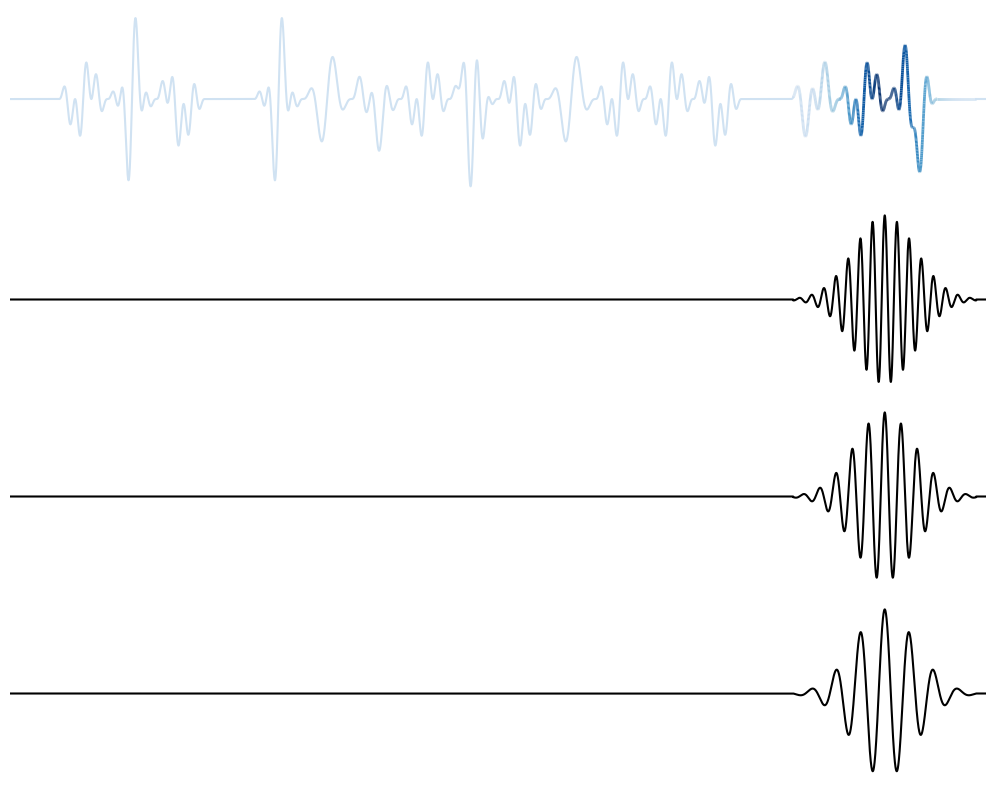

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

# --- Signal setup ---
fs = 8000
t = np.linspace(0, 1, fs, endpoint=False)
frequencies = [0.01, 0.0075, 0.005, 0.003]
#signal = sum(np.sin(2 * np.pi * f * np.arange(fs)) for f in frequencies)
#signal /= np.max(np.abs(signal))  # normalize
data = signal

# --- Parameters ---
window_size = 1500
hop_size = 60
sigma = window_size / 6

# Precompute Morlet wavelets (real part only)
n = np.arange(window_size)
t_wave = n - window_size / 2
morlets = {
    f: np.cos(2 * np.pi * f * t_wave) * np.exp(-t_wave**2 / (2 * sigma**2))
    for f in frequencies
}

# Gaussian window for coloring
g = np.exp(-0.5 * ((np.arange(window_size) - window_size / 2) / sigma) ** 2)
g /= np.max(g)
g_min = 50 / 255
norm_g = g * (1 - g_min) + g_min

low_color = plt.cm.Blues(.392 / 2)

# --- Plot setup ---
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Top plot (signal with highlighted window)
line_inactive1, = axs[0].plot([], [], color=low_color, linewidth=1.5)
line_inactive2, = axs[0].plot([], [], color=low_color, linewidth=1.5)
lc_active = LineCollection([], linewidth=2)
axs[0].add_collection(lc_active)
axs[0].set_yticks([])
axs[0].set_xlim(0, 1)
axs[0].set_ylim(data.min() * 1.1, data.max() * 1.1)

# Bottom plots: each Morlet wavelet
wavelet_lines = []
for ax in axs[1:]:
    line, = ax.plot([], [], color='black')
    wavelet_lines.append(line)
    ax.set_ylim(-1.1, 1.1)
    ax.set_yticks([])
    
for ax in axs: 
    ax.set_xticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)



# X-axis range
for ax in axs:
    ax.set_xlim(0, 1)

# --- Animation logic ---
def init():
    line_inactive1.set_data([], [])
    line_inactive2.set_data([], [])
    lc_active.set_segments([])
    for line in wavelet_lines:
        line.set_data([], [])
    return [line_inactive1, line_inactive2, lc_active, *wavelet_lines]

def update(frame_index):
    start = frame_index * hop_size
    end = start + window_size
    if end > len(data):
        return [line_inactive1, line_inactive2, lc_active, *wavelet_lines]

    # Update top signal plot
    line_inactive1.set_data(t[:start], data[:start])
    line_inactive2.set_data(t[end:], data[end:])
    highlight_t = t[start:end]
    highlight_x = data[start:end]
    points = np.array([highlight_t, highlight_x]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = plt.cm.Blues(norm_g[:-1])
    lc_active.set_segments(segments)
    lc_active.set_color(colors)

    # Update Morlet plots
    for i, f in enumerate(frequencies[:-1]):
        w_plot = np.zeros_like(data)
        w_plot[start:end] = morlets[f]
        wavelet_lines[i].set_data(t, w_plot)

    return [line_inactive1, line_inactive2, lc_active, *wavelet_lines]

num_frames = (len(data) - window_size) // hop_size

ani = FuncAnimation(
    fig, update, frames=num_frames, init_func=init,
    blit=True, interval=30, repeat=False
)

plt.tight_layout()
ani.save('gifs/wavelets.gif',writer='pillow', fps=20)
plt.show()


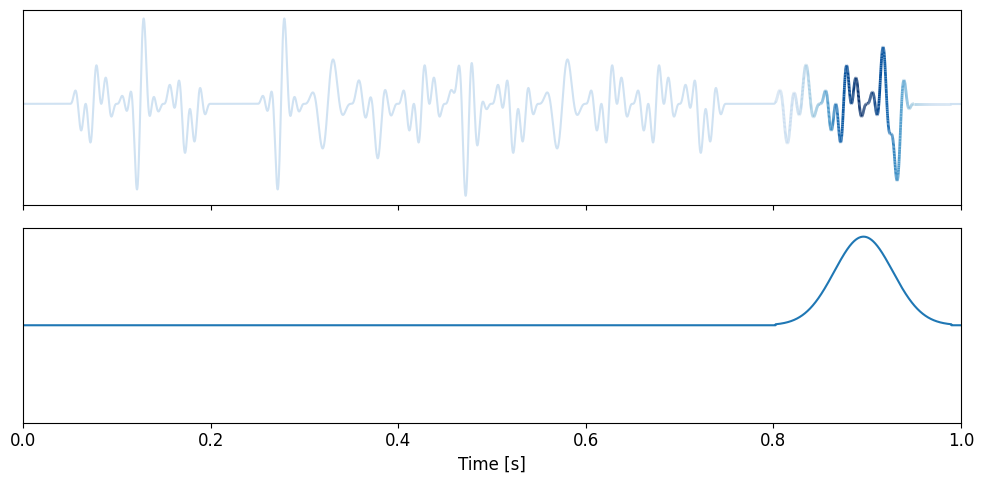

In [270]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

# Signal parameters
fs = 8000
t = np.linspace(0, 1, fs, endpoint=False)
x = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 660 * t) 
# Frequencies in cycles per sample
frequencies = [0.003, 0.005, 0.0075, 0.01]

# Generate signal: sum of sinusoids
#signal = sum(np.sin(2 * np.pi * f * np.arange(fs)) for f in frequencies) # Example signal
#signal /= np.max(np.abs(signal))
data1 = signal

#x = data
# Gabor transform parameters
window_size = 1500
hop_size = 60
sigma = window_size / 6
f0 = 0.005  # cycles per sample for Morlet



# Morlet wavelet (real part)
n = np.arange(window_size)
t_wave = n - window_size / 2
morlet_real = np.cos(2 * np.pi * f0 * t_wave) * np.exp(-t_wave**2 / (2 * sigma**2))

# Gaussian window (for coloring)
g = morlet_real * np.exp(-t_wave**2 / (2 * sigma**2))
g = np.exp(-0.5 * ((np.arange(window_size) - window_size / 2) / sigma) ** 2)
g /= np.max(g)
g_min = 50 / 255
norm_g = g * (1 - g_min) + g_min

# Colormap for inactive signal
low_color = plt.cm.Blues(.392 / 2)

# Set up plot
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

line_inactive1, = axs[0].plot([], [], color=low_color, linewidth=1.5)
line_inactive2, = axs[0].plot([], [], color=low_color, linewidth=1.5)
lc_active = LineCollection([], linewidth=2)
axs[0].add_collection(lc_active)
axs[0].set_yticks([])

wavelet_line, = axs[1].plot([], [])
axs[1].set_yticks([])
axs[1].set_xlabel("Time [s]")

axs[0].set_xlim(0, 1)
axs[0].set_ylim(data1.min() * 1.1, data1.max() * 1.1)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(-1.1, 1.1)

def init():
    line_inactive1.set_data([], [])
    line_inactive2.set_data([], [])
    lc_active.set_segments([])
    wavelet_line.set_data([], [])
    return line_inactive1, line_inactive2, lc_active, wavelet_line

def update(frame_index):
    start = frame_index * hop_size
    end = start + window_size
    if end > len(data1):
        return line_inactive1, line_inactive2, lc_active, wavelet_line

    # Top plot (highlighted region)
    line_inactive1.set_data(t[:start], data1[:start])
    line_inactive2.set_data(t[end:], data1[end:])
    highlight_t = t[start:end]
    highlight_x = data1[start:end]
    points = np.array([highlight_t, highlight_x]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = plt.cm.Blues(norm_g[:-1])
    lc_active.set_segments(segments)
    lc_active.set_color(colors)

    # Bottom plot (wavelet)
    w_plot = np.zeros_like(x)
    w_plot[start:end] = g
    wavelet_line.set_data(t, w_plot)

    return line_inactive1, line_inactive2, lc_active, wavelet_line

num_frames = (len(data) - window_size) // hop_size

ani = FuncAnimation(
    fig, update, frames=num_frames, init_func=init,
    blit=True, interval=30, repeat=False
)

ani.save('gifs/transientsnarrow.gif', writer='pillow', fps=20)
plt.tight_layout()
plt.show()


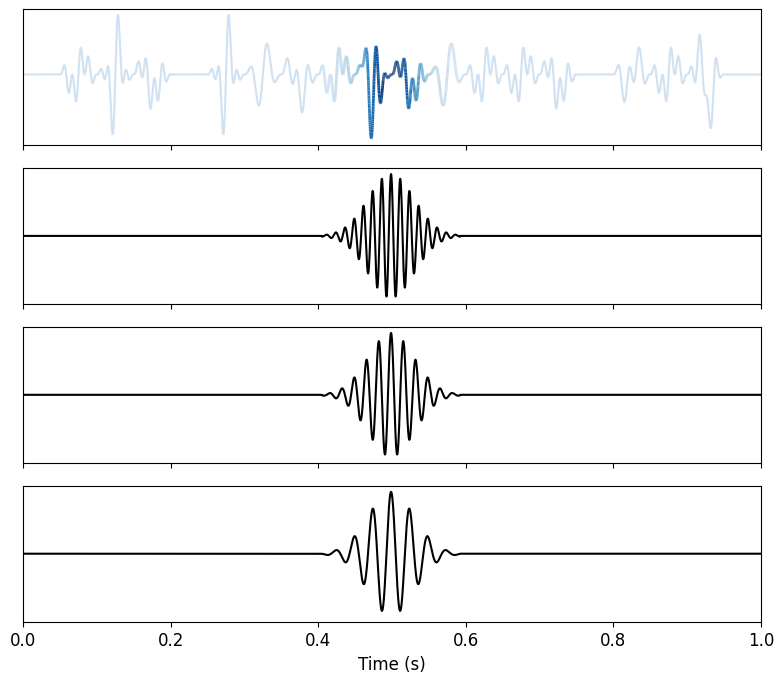

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
plt.rcParams.update({'font.size': 12})
# --- Signal setup ---
fs = 8000
t = np.linspace(0, 1, fs, endpoint=False)
frequencies = [0.01, 0.0075, 0.005, 0.003]
# using predefined signal
data = signal

# --- Parameters ---
window_size = 1500
hop_size = 60
sigma = window_size / 6

# Precompute Morlet wavelets (real part only)
n = np.arange(window_size)
t_wave = n - window_size / 2
morlets = {
    f: np.cos(2 * np.pi * f * t_wave) * np.exp(-t_wave**2 / (2 * sigma**2))
    for f in frequencies
}

# Gaussian window for coloring
g = np.exp(-0.5 * ((np.arange(window_size) - window_size / 2) / sigma) ** 2)
g /= np.max(g)
g_min = 50 / 255
norm_g = g * (1 - g_min) + g_min

low_color = plt.cm.Blues(.392 / 2)

# --- Plot setup ---
fig, axs = plt.subplots(4, 1, figsize=(8, 7), sharex=True)

# Middle frame index
num_frames = (len(data) - window_size) // hop_size
frame_index = num_frames // 2
start = frame_index * hop_size
end = start + window_size

# Top plot (signal with highlighted window)
axs[0].plot(t[:start], data[:start], color=low_color, linewidth=1.5)
axs[0].plot(t[end:], data[end:], color=low_color, linewidth=1.5)

highlight_t = t[start:end]
highlight_x = data[start:end]
points = np.array([highlight_t, highlight_x]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = plt.cm.Blues(norm_g[:-1])
lc_active = LineCollection(segments, colors=colors, linewidth=2)
axs[0].add_collection(lc_active)

axs[0].set_xlim(0, 1)
axs[0].set_ylim(data.min() * 1.1, data.max() * 1.1)
axs[0].set_yticks([])

# Bottom plots: each Morlet wavelet
for i, ax in enumerate(axs[1:]):
    f = frequencies[i]
    w_plot = np.zeros_like(data)
    w_plot[start:end] = morlets[f]
    ax.plot(t, w_plot, color='black')
    ax.set_ylim(-1.1, 1.1)
    ax.set_yticks([])

axs[-1].set_xlabel("Time (s)")
# Clean up axes
'''
for ax in axs:
    ax.set_xticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

        '''
plt.tight_layout()
plt.show()


1201
1601
2401


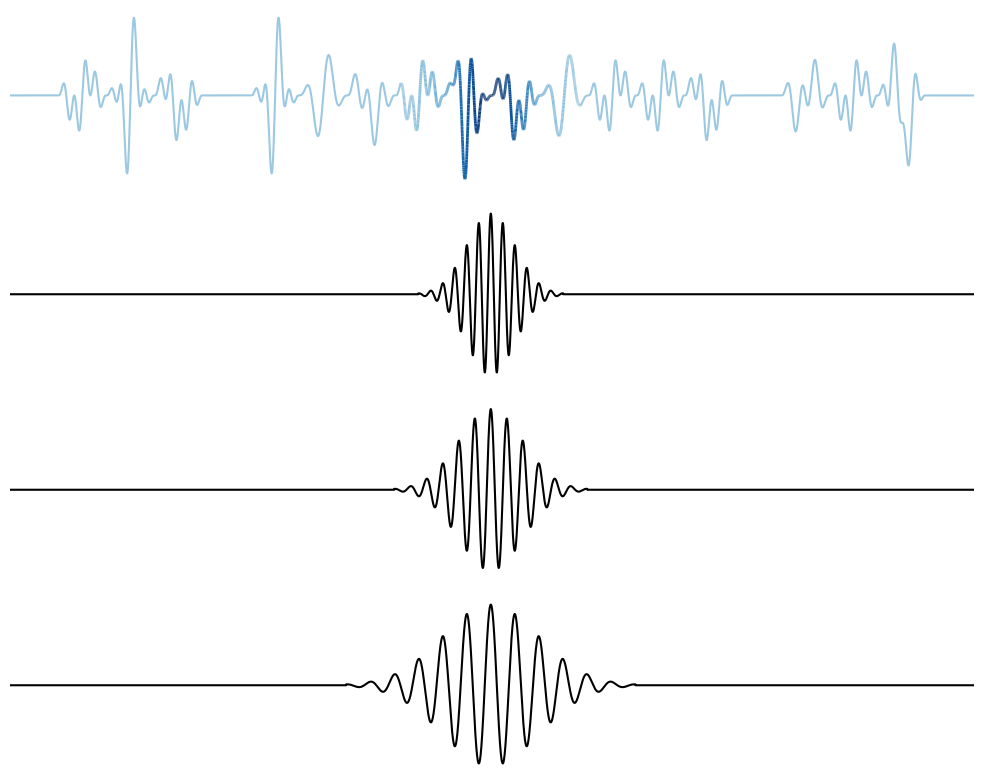

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# --- Signal setup ---
fs = 8000
t = np.linspace(0, 1, fs, endpoint=False)
frequencies = [0.01, 0.0075, 0.005, 0.003]
# using predefined signal
data = signal  # assume `signal` is defined elsewhere

# --- Parameters ---
base_window_size = 1500  # size for signal highlight
hop_size = 60
N_cycles = 6  # same number of oscillations for each wavelet

# --- Frame setup ---
num_frames = (len(data) - base_window_size) // hop_size
frame_index = num_frames // 2
start = frame_index * hop_size
end = start + base_window_size
center = start + base_window_size // 2

# --- Gaussian window for coloring ---
sigma = base_window_size / 6
g = np.exp(-0.5 * ((np.arange(base_window_size) - base_window_size / 2) / sigma) ** 2)
g /= np.max(g)
g_min = 50 / 255
norm_g = g * (1 - g_min) + g_min
low = .38
low_color = plt.cm.Blues(low)

# --- Precompute Morlets ---
morlets = {}
window_sizes = {}

for f in frequencies:
    duration = N_cycles / f/4000
    window_size = int(duration * fs)
    if window_size % 2 == 0:
        window_size += 1
    t_wave = np.arange(window_size) - window_size // 2
    sigma_f = window_size / 6
    morlet = np.cos(2 * np.pi * f * t_wave) * np.exp(-t_wave**2 / (2 * sigma_f**2))
    morlets[f] = morlet
    window_sizes[f] = window_size

# --- Plotting ---
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Signal plot
axs[0].plot(t[:start], data[:start], color=low_color, linewidth=1.5)
axs[0].plot(t[end:], data[end:], color=low_color, linewidth=1.5)

highlight_t = t[start:end]
highlight_x = data[start:end]
points = np.array([highlight_t, highlight_x]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# --- Color gradient setup ---
fade_min = low # match inactive color

norm_g = np.exp(-0.5 * ((np.arange(base_window_size) - base_window_size / 2) / sigma) ** 2)
norm_g -= norm_g.min()
norm_g /= norm_g.max()
norm_g = norm_g * (1 - fade_min) + fade_min
colors = plt.cm.Blues(norm_g[:-1])
lc_active = LineCollection(segments, colors=colors, linewidth=2)
axs[0].add_collection(lc_active)

axs[0].set_xlim(0, 1)
axs[0].set_ylim(data.min() * 1.1, data.max() * 1.1)
axs[0].set_yticks([])

# Morlet wavelet plots
for i, f in enumerate(frequencies[:-1]):
    ax = axs[i+1]
    morlet = morlets[f]
    win = window_sizes[f]
    print(win)
    half = win // 2
    s = center - half
    e = s + win

    w_plot = np.zeros_like(data)
    if s >= 0 and e <= len(data):
        w_plot[s:e] = morlet
        ax.plot(t, w_plot, color='black')

    ax.set_ylim(-1.1, 1.1)
    ax.set_yticks([])

#axs[-1].set_xlabel("Time (s)")
# Clean up axes
for ax in axs:
    ax.set_xticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()


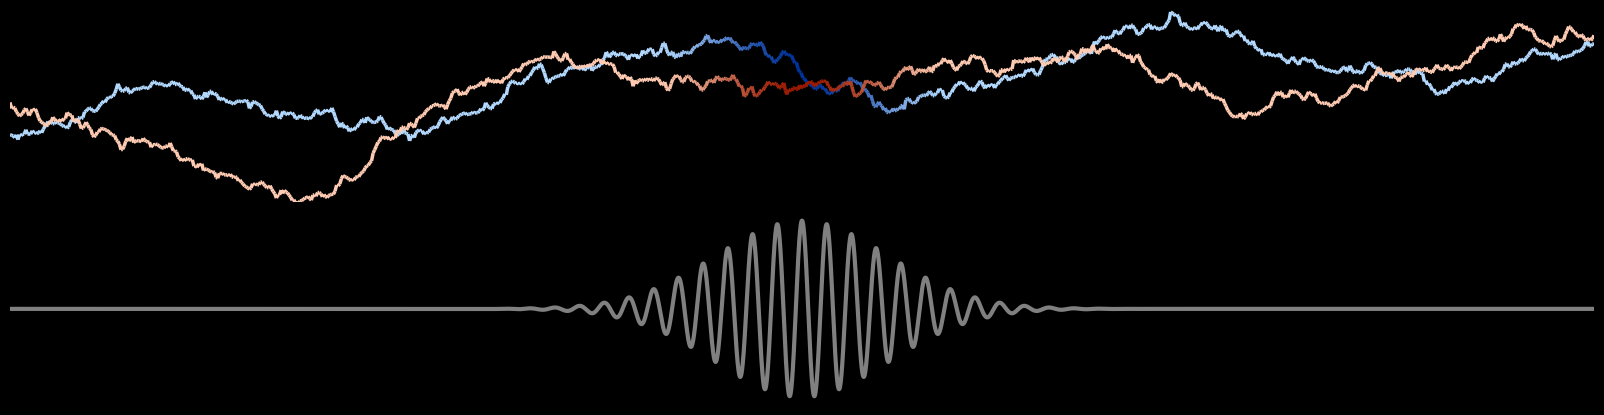

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.ndimage import gaussian_filter1d
from matplotlib.collections import LineCollection
# Dark background

# Sampling
fs = 1000
t = np.linspace(0, 1, fs)

# Simulate two "stock price" signals with noise + smoothing
np.random.seed(1)
raw1 = np.cumsum(np.random.randn(fs)) * 0.3 + 100
raw2 = np.cumsum(np.random.randn(fs)) * 0.3 + 80
price1 = raw1+np.sin(2 * np.pi * 3 * t) * 5  # Add a sine wave for periodicity
price2 = raw2+np.cos(2 * np.pi * 3 * t) * 5  # Add a cosine wave for periodicity
# Amplify the swings
price1 = (price1 - np.mean(price1)) * 10 + 100  # center at 100
price2 = (price2 - np.mean(price2)) * 10 + 80   # center at 80


# Overlap region fade (symmetric)
overlap_start = 0.4
overlap_end = 0.6
fade_region = (t >= overlap_start) & (t <= overlap_end)
fade_vals = 0.5 * (1 - np.cos(2 * np.pi * (t[fade_region] - overlap_start) / (overlap_end - overlap_start)))
fade = np.zeros_like(t)
fade[fade_region] = fade_vals

# Build colored line segments for both signals
def build_faded_line(t, y, fade, base_color, fade_color, linewidth=2.5):
    points = np.array([t, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = [
        tuple(
            base_color[i] * (1 - a) + fade_color[i] * a
            for i in range(3)
        ) for a in fade[:-1]
    ]
    return LineCollection(segments, colors=colors, linewidth=linewidth)

# Color definitions (light → dark fade)
color1_light = (0.7, 0.85, 1.0)  # light blue
color1_dark  = (0.0, 0.2, 0.6)   # dark blue

color2_light = (1.0, 0.8, 0.7)   # light salmon
color2_dark  = (0.6, 0.1, 0.0)   # dark red

lc1 = build_faded_line(t, price1, fade, color1_light, color1_dark)
lc2 = build_faded_line(t, price2, fade, color2_light, color2_dark)

# Morlet wavelet
wavelet = pywt.ContinuousWavelet('cmor1.5-4.0')
psi, x = wavelet.wavefun(level=20)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(15.84, 3.96), dpi=100)

# Top: Two "stock" lines
axs[0].add_collection(lc1)
axs[0].add_collection(lc2)
axs[0].set_xlim(t[0], t[-1])
combined = np.concatenate([price1, price2])
axs[0].set_ylim(combined.min() * 0.98, combined.max() * 1.02)

# Bottom: Wavelet in red
axs[1].plot(x, np.real(psi), color='grey', linewidth=3.0)
axs[1].set_xlim(x[0], x[-1])

# Clean visuals
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
# Dark background
plt.style.use('dark_background')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.05)
plt.show()


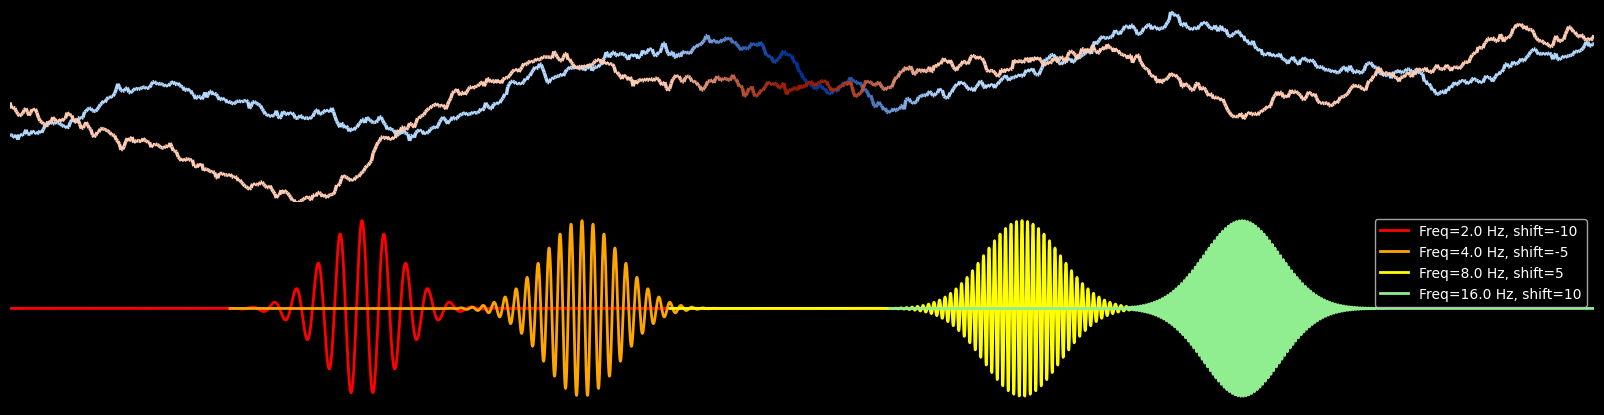

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from matplotlib.collections import LineCollection

plt.style.use('dark_background')

fs = 1000
t = np.linspace(0, 1, fs)

np.random.seed(1)
raw1 = np.cumsum(np.random.randn(fs)) * 0.3 + 100
raw2 = np.cumsum(np.random.randn(fs)) * 0.3 + 80
price1 = raw1 + np.sin(2 * np.pi * 3 * t) * 5
price2 = raw2 + np.cos(2 * np.pi * 3 * t) * 5

price1 = (price1 - np.mean(price1)) * 10 + 100
price2 = (price2 - np.mean(price2)) * 10 + 80

overlap_start = 0.4
overlap_end = 0.6
fade_region = (t >= overlap_start) & (t <= overlap_end)
fade_vals = 0.5 * (1 - np.cos(2 * np.pi * (t[fade_region] - overlap_start) / (overlap_end - overlap_start)))
fade = np.zeros_like(t)
fade[fade_region] = fade_vals

def build_faded_line(t, y, fade, base_color, fade_color, linewidth=2.5):
    points = np.array([t, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = [
        tuple(
            base_color[i] * (1 - a) + fade_color[i] * a
            for i in range(3)
        ) for a in fade[:-1]
    ]
    return LineCollection(segments, colors=colors, linewidth=linewidth)

color1_light = (0.7, 0.85, 1.0)
color1_dark  = (0.0, 0.2, 0.6)
color2_light = (1.0, 0.8, 0.7)
color2_dark  = (0.6, 0.1, 0.0)

lc1 = build_faded_line(t, price1, fade, color1_light, color1_dark)
lc2 = build_faded_line(t, price2, fade, color2_light, color2_dark)

fig, axs = plt.subplots(2, 1, figsize=(15.84, 3.96), dpi=100)

axs[0].add_collection(lc1)
axs[0].add_collection(lc2)
axs[0].set_xlim(t[0], t[-1])
combined = np.concatenate([price1, price2])
axs[0].set_ylim(combined.min() * 0.98, combined.max() * 1.02)

freqs = [2.0, 4.0, 8.0, 16.0]
colors = ['red', 'orange', 'yellow', 'lightgreen']
shifts = [-10, -5, 5, 10]  # wider spacing

for f, c, s in zip(freqs, colors, shifts):
    wavelet = pywt.ContinuousWavelet(f'cmor1.5-{f}')
    psi, x = wavelet.wavefun(level=20)
    axs[1].plot(x + s, np.real(psi), color=c, linewidth=2, label=f'Freq={f} Hz, shift={s}')

axs[1].set_xlim(min(x + shifts[0]), max(x + shifts[-1]))
axs[1].legend(loc='upper right')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.05)
plt.show()


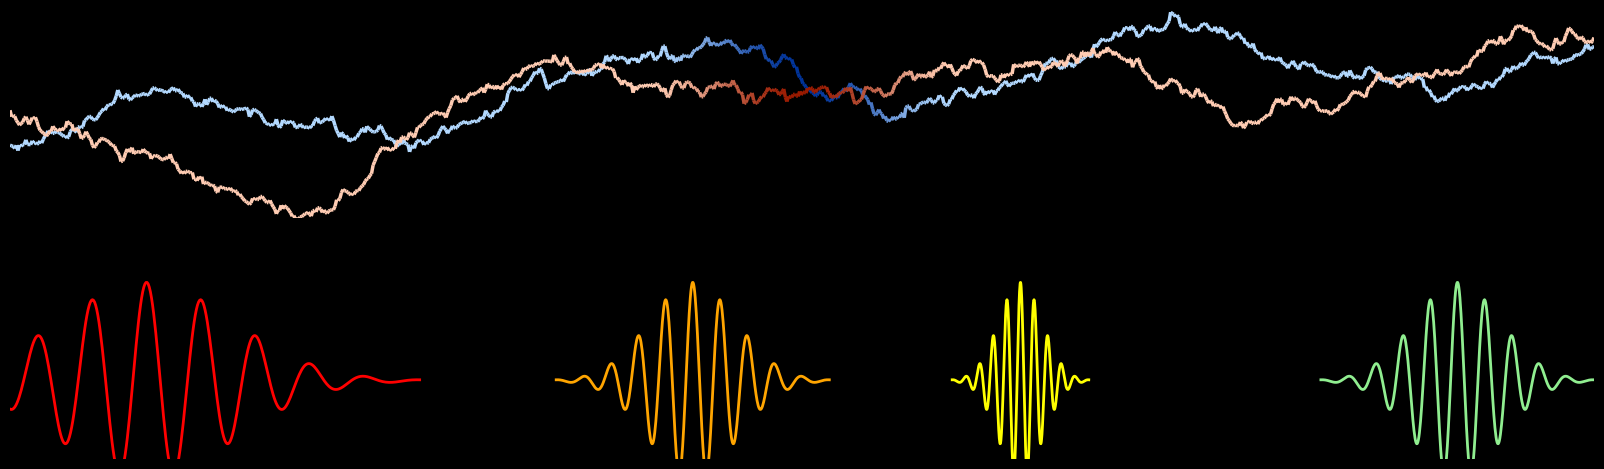

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.style.use('dark_background')

# Sampling for the stock prices
fs = 1000
t = np.linspace(0, 1, fs)

np.random.seed(1)
raw1 = np.cumsum(np.random.randn(fs)) * 0.3 + 100
raw2 = np.cumsum(np.random.randn(fs)) * 0.3 + 80
price1 = raw1 + np.sin(2 * np.pi * 3 * t) * 5
price2 = raw2 + np.cos(2 * np.pi * 3 * t) * 5

price1 = (price1 - np.mean(price1)) * 10 + 100
price2 = (price2 - np.mean(price2)) * 10 + 80

# Overlap region fade (symmetric)
overlap_start = 0.4
overlap_end = 0.6
fade_region = (t >= overlap_start) & (t <= overlap_end)
fade_vals = 0.5 * (1 - np.cos(2 * np.pi * (t[fade_region] - overlap_start) / (overlap_end - overlap_start)))
fade = np.zeros_like(t)
fade[fade_region] = fade_vals

def build_faded_line(t, y, fade, base_color, fade_color, linewidth=2.5):
    points = np.array([t, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = [
        tuple(
            base_color[i] * (1 - a) + fade_color[i] * a
            for i in range(3)
        ) for a in fade[:-1]
    ]
    return LineCollection(segments, colors=colors, linewidth=linewidth)

color1_light = (0.7, 0.85, 1.0)
color1_dark  = (0.0, 0.2, 0.6)
color2_light = (1.0, 0.8, 0.7)
color2_dark  = (0.6, 0.1, 0.0)

lc1 = build_faded_line(t, price1, fade, color1_light, color1_dark)
lc2 = build_faded_line(t, price2, fade, color2_light, color2_dark)

fig, axs = plt.subplots(2, 1, figsize=(15.84, 4.5), dpi=100)

# Top subplot: stock price signals with fade
axs[0].add_collection(lc1)
axs[0].add_collection(lc2)
axs[0].set_xlim(t[0], t[-1])
combined = np.concatenate([price1, price2])
axs[0].set_ylim(combined.min() * 0.98, combined.max() * 1.02)

# Bottom subplot: Morlet wavelets with same number of oscillations and horizontal shifts
N_oscillations = 10
freqs = [2, 4, 8, 4]
colors = ['red', 'orange', 'yellow', 'lightgreen']
shifts = [-5, 0, 3, 7]

for f, c, s in zip(freqs, colors, shifts):
    # Duration for fixed number of oscillations
    T = N_oscillations / f
    t_wave = np.linspace(-T/2, T/2, 500)
    
    # Approximate std deviation to fit N oscillations within the window
    sigma = N_oscillations / (2 * np.pi * f)
    
    # Morlet wavelet real part (normalized)
    wavelet = (np.pi ** (-0.25)) * np.cos(2 * np.pi * f * t_wave) * np.exp(-t_wave**2 / (2 * sigma**2))
    
    axs[1].plot(t_wave + s, wavelet, color=c, linewidth=2, label=f'{f} Hz')

axs[1].set_xlim(min(t_wave + shifts[0]), max(t_wave + shifts[-1]))
axs[1].set_ylim(-0.6, 1.0)  # fix y limits for better visual comparison

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.15)
plt.show()


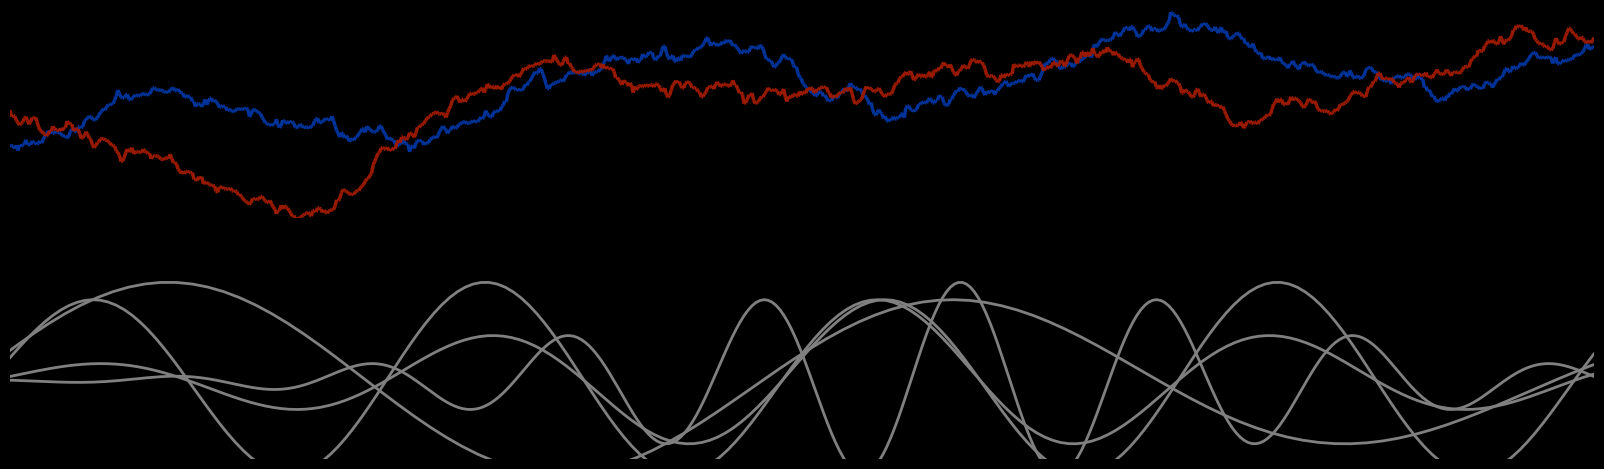

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.style.use('dark_background')

# Sampling for the stock prices
fs = 1000
t = np.linspace(0, 1, fs)

np.random.seed(1)
raw1 = np.cumsum(np.random.randn(fs)) * 0.3 + 100
raw2 = np.cumsum(np.random.randn(fs)) * 0.3 + 80
price1 = raw1 + np.sin(2 * np.pi * 3 * t) * 5
price2 = raw2 + np.cos(2 * np.pi * 3 * t) * 5

price1 = (price1 - np.mean(price1)) * 10 + 100
price2 = (price2 - np.mean(price2)) * 10 + 80

def build_faded_line(t, y, fade, base_color, fade_color, linewidth=2.5):
    points = np.array([t, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = [
        tuple(
            base_color[i] * (1 - a) + fade_color[i] * a
            for i in range(3)
        ) for a in fade[:-1]
    ]
    return LineCollection(segments, colors=colors, linewidth=linewidth)

color1_light = (0.7, 0.85, 1.0)
color1_dark  = (0.0, 0.2, 0.6)
color2_light = (1.0, 0.8, 0.7)
color2_dark  = (0.6, 0.1, 0.0)

# Wavelet parameters
N_oscillations = 10
freqs = [2, 4, 8, 4]

# Positions for wavelets and fades in the signal time domain [0,1]
shifts = [0.1, 0.3, 0.6, 0.8]

# Initialize fade arrays for both signals (fully light)
fade1 = np.zeros_like(t)
fade2 = np.zeros_like(t)

# Build fade regions aligned with wavelets
for f, s in zip(freqs, shifts):
    T = N_oscillations / f          # duration of wavelet window
    left = s - T/2
    right = s + T/2
    
    # Boolean index for fade region, clipped to signal domain
    fade_region = (t >= left) & (t <= right)
    if not np.any(fade_region):
        continue
    
    # Cosine fade envelope: 0 → 1 → 0 within each fade region
    fade_vals = 0.5 * (1 - np.cos(2 * np.pi * (t[fade_region] - left) / (right - left)))
    
    # Add fades (sum in case of overlap)
    fade1[fade_region] += fade_vals
    fade2[fade_region] += fade_vals

# Clip fades to max 1 to avoid over-darkening
fade1 = np.clip(fade1, 0, 1)
fade2 = np.clip(fade2, 0, 1)

# Build LineCollections for signals with multiple fade highlights
lc1 = build_faded_line(t, price1, fade1, color1_light, color1_dark)
lc2 = build_faded_line(t, price2, fade2, color2_light, color2_dark)

fig, axs = plt.subplots(2, 1, figsize=(15.84, 4.5), dpi=100)

# Plot top signals with fade highlights
axs[0].add_collection(lc1)
axs[0].add_collection(lc2)
axs[0].set_xlim(t[0], t[-1])
combined = np.concatenate([price1, price2])
axs[0].set_ylim(combined.min() * 0.98, combined.max() * 1.02)

for f, s in zip(freqs, shifts):
    T = N_oscillations / f
    # Create t_wave linearly spaced inside the fade window, so wavelet fits exactly
    t_wave = np.linspace(s - T/2, s + T/2, 500)
    # Wavelet time vector centered at 0 for calculation
    t_wave_centered = t_wave - s
    sigma = N_oscillations / (2 * np.pi * f)
    wavelet = (np.pi ** (-0.25)) * np.cos(2 * np.pi * f * t_wave_centered) * np.exp(-t_wave_centered**2 / (2 * sigma**2))
    axs[1].plot(t_wave, wavelet, color='grey', linewidth=2)

axs[1].set_xlim(0, 1)
axs[1].set_ylim(-0.6, 1.0)

# Clean axes for clarity
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.15)
plt.show()
